# Tweets classification using Arabic ULMFIT model
### You can get this dataset from [Link](https://github.com/bakrianoo/Datasets/tree/master/Arabic%20Tweets)
This dataset contains A corpus of Arabic tweets categorized to positive and negative sentiments based on some emoji characters appearance.

Category       | Tweets No.  |
-----  | --------             |
Positive Tweets |   2,104,671   |
Negative Tweets |   2,313,457   |

##### *Citation*:
> Abu Bakr Soliman. (2017). Arabic Datasets for research purposes [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1034601

For more information about ULMFIT see [Paper](https://arxiv.org/abs/1801.06146) & [Blog post](http://nlp.fast.ai/).

### Using our pretrained Arabic ULMFIT language model we do the following:
1- Preprocess our dataset and get it ready for use in the coming steps by creating a language model databunch & classifer databunch.

2- Load our language model with pretrained weights then fine-tune it to our dataset.

3- Create a classifier on top of the encoder of the language model.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import path 
from fastai.text import *
import copy

In [5]:
import fastai; fastai.__version__

'1.0.51.dev0'

In [60]:
data_path = Path('data')
lm_path = Path('.')

### 1- Pre-processing our Dataset :

**We start by reading the 2 text files concatinating them in a single csv file**

In [7]:
with open(data_path/'tweets.csv','w') as file:
    writer = csv.writer(file,delimiter=',')
    with open(data_path/'pos_arabic.txt', "r") as pos:
        for line in pos:
            line = line.rstrip('\n')
            tweet = line.split('\t')[-1]
            writer.writerow([tweet,'pos'])
    print('Finished positive tweets')
    with open(data_path/'neg_arabic.txt', "r") as neg:
        for line in neg:
            line = line.rstrip('\n')
            tweet = line.split('\t')[-1]
            writer.writerow([tweet,'neg'])
    print('Finished negative tweets')
            
            

Finished positive tweets
Finished negative tweets


In [9]:
tweets_df = pd.read_csv(data_path/'tweets.csv',names=['tweet','sentiment'],low_memory = False)
print(tweets_df.shape)
#Remove NaNs from df
tweets_df = tweets_df.dropna(axis=0)
print(tweets_df.shape)

(4418128, 2)
(4417200, 2)


In [10]:
tweets_df.head()

,tweet,sentiment
0,Capricorn's Woman: لها ذاكرة قوية ، تحفظ كثير...,pos
1,يَ آخر نفسسّ ؛ لـ أحلامنآ ﺂ لآ تطيحينّ ، ⁰ عَش...,pos
2,تـــــــــبــــــــــــادل اعــــــــــــــــل...,pos
3,“@Jabermmm: @AliAlMullaa الملا الساعه ٣ الصبح ...,pos
4,@mousa_a_alkhars الخرس .. مافي شيء أكيد غير ال...,pos


*Create A held-out test dataset using 10% of our full dataset. and drop it from the full dataset.*

In [11]:
test_df = tweets_df.sample(frac = .1 ,replace=False,random_state = 42)

In [12]:
tweets_df = tweets_df.drop(test_df.index)
tweets_df.shape

(3975480, 2)

*Create 2 csv files containing our train/valid and our test datasets.*

In [13]:
test_df.to_csv(data_path/'tweets_test.csv',index=False)
tweets_df.to_csv(data_path/'tweets_train.csv',index=False)

In [14]:
tweets_train_df = pd.read_csv(data_path/'tweets_train.csv')
tweets_test_df = pd.read_csv(data_path/'tweets_test.csv')

* Create a Language model databunch that does all the necessary preprocessing like tokenization and numericalization.

* All the text in the dataset is concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

* We also create a validation set that is 10% of our full dataset (80% train 10% valid 10% test).

In [15]:
tweets_lm_data = (TextList.from_df(tweets_df,cols=['tweet'])
                   .split_by_rand_pct(.1)
                   .label_for_lm()
                   .databunch(bs=64))

In [17]:
tweets_lm_data.show_batch()

idx,text
0,الصبح مالك نيه تروح تنام والا xxunk للحين xxunk مطير النوم من عيني :) xxbos xxunk xxunk .. مافي شيء أكيد غير الموت .. أطلع حله أطلع حله .. لازم يضبط : ) xxbos xxup xxunk xxrep 8 ه من شق ثوب الناس xxunk xxunk :-) xxbos xxunk xxunk دي شوية صعبة . قريتها بالعربي . دايرة مراجعه xxunk :) xxbos xxunk xxrep 8 3 xxunk : ) ترا عندي
1,"xxbos بلد كل ماله نرجع وراء . اجل xxunk عشان xxunk xxunk حقين جدة xxunk في بيوتهم :) t xxunk _ : احد يخبر لي شقه xxunk ؟ # الهجره xxbos xxunk فيه قائمة انتظار http : / / xxunk / xxunk # xxunk :) xxbos # women2drive أحبتي , هل هناك نص مثبت يمنع المرأه من القيادة ؟ + الي يرددون نظام , قانون , عقاب / فاكرين فيه"
2,"والكل يعرف هالشئ , وكل العالم كذا الا حنا :) xxbos xxunk xxunk xxunk يبيله حبة حساسية و xxunk على ط xxrep 4 و ل :)) xxbos قآلوآ لي xxunk لآ xxunk xxunk : ' xxunk xxunk xxunk هو آلي xxunk : ' :) xxbos xxunk xxunk xxrep 15 ه زين ما xxunk xxrep 14 ه جان xxunk xxunk :) xxbos الا ياهل xxunk xxunk .. xxunk نبي xxunk خليه"
3,الأخوة xxunk لم أكن xxunk ترشيح نفسى للرئاسة .. لكن قدر الله وماشاء فعل .. xxup :d xxbos “ xxup xxunk : @bumberqueen العفو في زمانا هذا اصبح القليل من الناس xxunk مثل xxunk xxunk ولا يديد xxunk : ) xxunk xxunk xxbos @arabicobama الليلة ، بكرا استعداد xxunk ، ما بتلاقي شي xxunk :-) xxbos بِسْمِ اللّهِ الرَّحْمَنِ الرَّحِيْمِ selamat xxunk :)) xxbos “ xxunk : xxunk xxunk xxunk
4,دفتر xxunk : ) ” xxbos يارب أخشى أن أموت فجأة .. دون أن أرتب توبة في صدري : ) \ ' يارب إغفرلي إذا مت ! وإجعل مايبقى مني أثر طيب يترك إبتسامة .. xxbos تستحق المتابعه :) fb.me / xxunk xxbos معليش xxunk كانت مجنونه :) . xxup rt xxunk : xxunk اللحظة المرعبة لما تعصب الشغالة =) ) xxrep 8 ه تذكرتك يوم تخافين من xxunk المرعبه


*Save our databunch so we can load it instantly later if we want.*

In [18]:
tweets_lm_data.save('tweets_lm')

In [19]:
tweets_lm_data = load_data(lm_path,'tweets_lm')

* Create a classification databunch that does all the necessary preprocessing like tokenization and numericalization.
* We also pass the vocabulary (mapping from ids to words) that we want to use to ensure that our classification databunch will use the same dictionary as our language model databunch.

In [20]:
tweets_cls_data = (TextList.from_df(tweets_df,vocab=tweets_lm_data.train_ds.vocab)
                   .split_by_rand_pct(.1)
                   .label_from_df(cols=['sentiment'])
                   .databunch(bs=64))

In [21]:
tweets_cls_data.show_batch()

text,target
xxbos xxunk xxunk ... :- ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( : ' ( :,neg
xxbos درجات الحرارة الآن في مناطق الكويت - xxunk : ( -1 ) ، العبدلي : ( 0 ) ، المطار : ( 2 ) ، الجهراء : ( 3 ) ، xxunk : ( 3 ) ، xxunk : ( 6 ) ♥,neg
xxbos محشش دقت عليه ﺂمہ ! = ) ) قآلٺ ﻟہ : يآ ولدي آرسل لي رصيد : ( قآل لهآ : ﺂضحڳي على غيريَ مآني # خر xxrep 4 و ف / :) ﺂمڳ # يآحيوآن xxup =d \ xxup =d /,neg
xxbos وحده تقول لي ان يوم القيامه قريب ! ! وش ذا : ( ! ! وانا لما الحين ما xxunk :( ! ! ولا جبت عيال :( ! ! ولا تخرجت :( ! ! ولا تعلمت فوتوشوب :( ! ! # صياح,neg
xxbos “ xxunk : ودي أصدق بس xxunk مو معق xxrep 5 و ل ! ! ! أهل السوق اللي xxunk له سهم xxunk : ) xxunk / 83 / ad / xxunk … ? ” xxrep 4 ه طاب على xxunk xxunk,pos


In [22]:
tweets_cls_data.save('tweets_cls')

In [23]:
tweets_cls_data = load_data(lm_path,'tweets_cls')

## 2- Fine-tune our LM to our Dataset:

In [24]:
pretrained_lm_fname = 'new_lm'
pretrained_itos_fname = 'itos'

* We will create a uni-directional [QRNN] (https://arxiv.org/abs/1611.01576) that will load our pre-trained language model weights stored in `new_lm.pth` and also load  `itos.pkl`  which contains our id to token mapping.
* We also pass it our language model databunch which we will fine-tune our language model to.

In [25]:
emb_sz:int = 400
nh: int = 1550
nl: int = 3

qrnn_config = copy.deepcopy(awd_lstm_lm_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [26]:
lm_learner = language_model_learner(tweets_lm_data, AWD_LSTM, config=qrnn_config, model_dir=lm_path, pretrained=False,drop_mult=.1,pretrained_fnames=(pretrained_lm_fname,pretrained_itos_fname))

In [27]:
lm_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


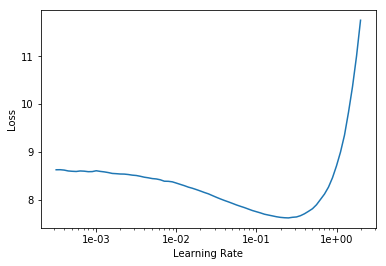

In [28]:
lm_learner.recorder.plot(skip_end=10)

*We train our model starting from the last layer then unfreezing the model and training the entire network*

In [ ]:
lm_learner.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,time


In [28]:
lm_learner.save('stage1-lm-1epoch')

In [29]:
lm_learner.unfreeze()

In [30]:
lm_learner.fit_one_cycle(2,3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.890118,4.827839,0.324525,49:05
1,4.561367,4.493906,0.354013,49:03
2,4.229220,4.174074,0.383569,49:02


In [31]:
lm_learner.save('stage2-lm-2epoch')

In [ ]:
lm_learner.fit_one_cycle(2,3e-2)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
lm_learner.save('stage2-lm-4epoch')

* To evaluate our language model, we run the `Learner.predict` method specifying the number of words we want it to guess.
* We can see that the predicted words don't make much sense but are coherent and follow basic grammer thanks to our language model.

In [40]:
lm_learner.predict('الجو جميل',n_words=10)

'الجو جميل أوي ف المذاكرة ده عالم دهب معآه 3 درجه'

*We save the language model encoder to use it for classification in the next step.*

In [41]:
lm_learner.save_encoder('stage2-lm-enc')

### 3- Creating the classifer:

*We now use the classifer databunch we created earlier to build a classifier with our fine-tuned encoder.* 

In [42]:
qrnn_cls_config = copy.deepcopy(awd_lstm_clas_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_cls_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_cls_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [43]:
clas_learner = text_classifier_learner(tweets_cls_data,AWD_LSTM,config=qrnn_cls_config,pretrained=False, model_dir=lm_path,drop_mult=.1)

In [44]:
clas_learner.load_encoder('stage2-lm-enc')

In [45]:
clas_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


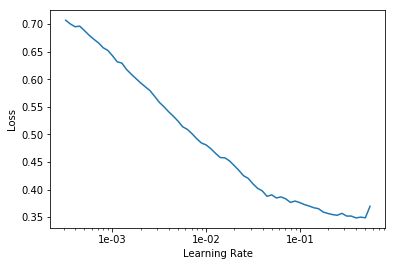

In [46]:
clas_learner.recorder.plot(skip_end=10)

*Again We train our model starting from the last layer then unfreezing the model and training the entire model*

In [47]:
clas_learner.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.074130,0.037626,0.987433,12:27


In [48]:
clas_learner.save('stage1-cls-1epoch')

In [49]:
clas_learner.unfreeze()

In [50]:
clas_learner.fit_one_cycle(2,2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.017127,0.013830,0.994768,32:08
1,0.017346,0.012080,0.995022,32:50


In [51]:
clas_learner.save('stage2-cls-2epoch')

*We can test our classifier by giving it a tweet and see the predicted sentiment and its propablity.*

In [52]:
clas_learner.predict('الشمس مشرقة')

(Category pos, tensor(1), tensor([0.3740, 0.6260]))

In [59]:
clas_learner.show_results()

text,target,prediction
xxbos “ xxunk : ┈ xxunk ┈ xxunk ┈ ┈ xxrep 4 xxunk ┈ xxrep 9 xxunk ┈ xxunk xxrep 4 ┈ xxunk xxrep 4 ┈ xxunk ┈ xxunk ┈ ┈ xxunk xxunk xxunk ┈ ┈ xxunk xxunk xxunk ┈ xxrep 5 xxunk ┈ xxunk xxrep 4 ┈ xxunk ┈ ┈ xxunk ┈ xxunk ┈ ┈ xxunk xxrep 4 ┈ xxunk ┈ ┈ xxunk 👍 👍 👍 xxunk ع xxup,pos,pos
xxbos ' @ : م xxrep 4 ـ اف xxrep 4 ـ ي xxunk xxrep 5 ـ ل م xxrep 4 ـ ن ان xxrep 4 ـ ك تت xxrep 4 ـ عرف عـــلى اح xxrep 5 ـ د بال xxrep 4 ـ صدفه xxunk xxrep 4 ـ ير اق xxrep 4 ـ رب ل xxrep 4 ـ ك م xxrep 4 ـ ن ك xxrep 5 ـ ل شــيء,pos,pos
xxbos ك xxrep 4 ـ ام ح xxrep 4 ـ د م xxrep 5 ـ ع xxrep 4 ـ اي xxrep 4 ـ ا ك xxrep 5 ـ ده ع xxrep 4 ـ ل xxrep 5 ـ ش xxrep 4 ـ ان ف xxrep 5 ـ ى مف xxrep 4 ـ xxunk ج xxrep 6 ـ xxrep 7 ا م xxrep 6 ـ ده :) دوس ... fb.me / xxunk,pos,pos
xxbos xxunk أحداث رمضان : xxunk وشرب - انتظار الراتب - سهر في xxunk حلاوة العيد ☕ xxunk 🍺 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 🍥 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 💰 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 💅 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,pos,pos
xxbos ' : ( أ - ب - ت - ث - ج - ح - خ - د - ذ - ر - ز - س - ش - ص - ض - ط - ظ - ع - غ - ف - ق - ك - ل - م - ن - ھ - و - ي ) xxunk لي xxunk من xxunk ♡ ',neg,neg


In [54]:
tweets_all_df = pd.concat([tweets_train_df,tweets_test_df])
tweets_all_df.shape

(4417200, 2)

In [55]:
tweets_cls_test_data = (TextList.from_df(tweets_all_df,vocab=tweets_lm_data.train_ds.vocab)
                   .split_by_idx(tweets_test_df.index)
                   .label_from_df(cols=['sentiment'])
                   .databunch(bs=64))

In [56]:
tweets_cls_data.save('tweets_cls_test')

In [57]:
#Validate returns (error rate , accuracy)
clas_learner.validate(tweets_cls_test_data.valid_dl)

[0.015487915, tensor(0.9915)]